Introduction

In [2]:
# Setup notebook
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

store_sales = pd.read_csv(
    'store-sales-time-series-forecasting//train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
        .groupby(['family', 'date'])
        .mean()
        .unstack('family')
        .loc['2017', ['sales', 'onpromotion']]
)


store_sales

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]

Her ürün ailesinde döngüsel davranış gösteren satışlar yoktur ve ortalama satışlar serisi de yoktur. Bununla birlikte, okul ve ofis malzemelerinin satışları, trend veya mevsimlerle iyi karakterize edilmeyen büyüme ve bozulma kalıpları göstermektedir. Bu soruda ve sonraki soruda, gecikme özelliklerini kullanarak okul ve ofis malzemeleri satışlarındaki döngüleri modelleyeceksiniz.

Trend ve mevsimsellik, hem korelogramlarda hem de gecikme grafiklerinde ortaya çıkan seri bağımlılık yaratacaktır. Herhangi bir tamamen döngüsel davranışı izole etmek için seriyi mevsimsellikten arındırarak başlayacağız. Tedarik Satışlarını mevsimsellikten arındırmak için sonraki hücredeki kodu kullanın. Sonucu bir y_deseason değişkeninde saklayacağız.

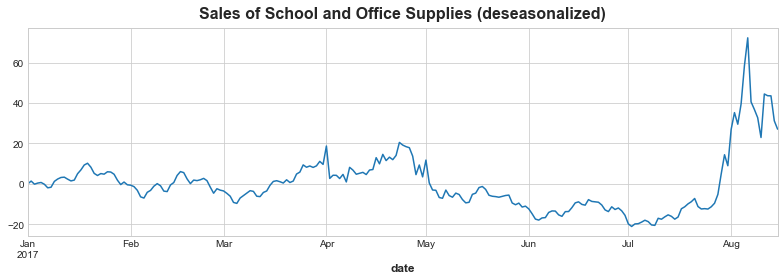

In [3]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

Bu mevsimsellikten arındırılmış seriler döngüsel kalıplar gösteriyor mu? Sezgimizi doğrulamak için, tıpkı trendde yaptığımız gibi hareketli ortalama grafiği kullanarak döngüsel davranışı izole etmeye çalışabiliriz. Buradaki fikir, kısa vadeli mevsimselliği yumuşatmak için yeterince uzun, ancak yine de döngüleri korumak için yeterince kısa bir pencere seçmektir.

1) Plotting cycles

Tedarik satışları serisi olan y'den yedi günlük hareketli ortalama (moving average plot) oluşturun. Ortalanmış bir pencere kullanın, ancak min_periods bağımsız değişkenini ayarlamayın.

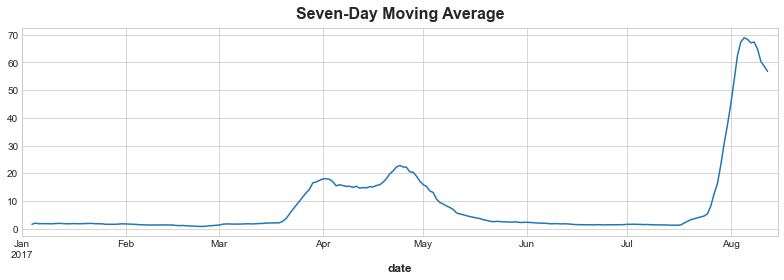

In [4]:
y_ma = y.rolling(window=7, center=True).mean()

# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");


Hareketli ortalama grafiğinin (moving average plot) mevsimsellikten arındırılmış dizinin konusuna nasıl benzediğini görüyor musunuz? Her ikisinde de belirtilen döngüsel davranışı görebiliriz.

Seri bağımlılık için mevsimsellikten arındırılmış serilerimizi inceleyelim. Kısmi otokorelasyon korelasyonuna ve gecikme grafiğine bir göz atın.

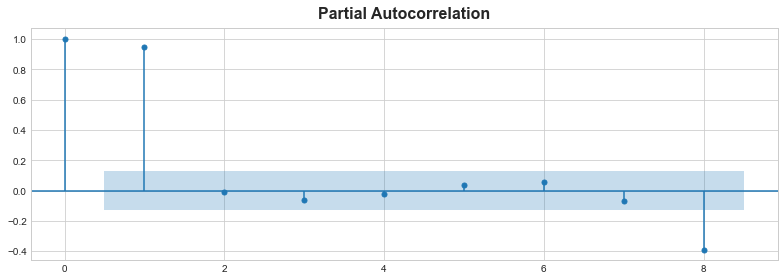

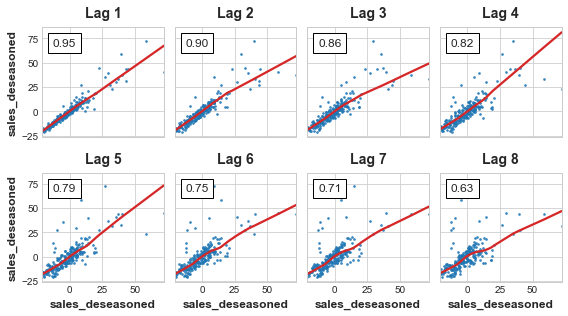

In [5]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

2) Mağaza Satışlarında seri bağımlılığı inceleyin (Examine serial dependence in Store Sales)

Korelograma göre herhangi bir gecikme önemli mi? Gecikme grafiği, korelogramdan belirgin olmayan herhangi bir ilişki öneriyor mu? Cevabınızı düşündükten sonra sonraki hücreyi çalıştırın.

Korelogram, muhtemelen sekizinci gecikmenin yanı sıra, ilk gecikmenin de önemli olabileceğini gösterir. Gecikme grafiği, etkinin çoğunlukla doğrusal olduğunu gösterir.

Öncü göstergenin (leading indicator), bir anda değerleri gelecekte hedefi tahmin etmek için kullanılabilecek bir dizi olduğunu öğreticiden hatırlayın - öncü gösterge (leading indicator), hedefteki değişikliklerin "önceden bildirimini" sağlar.

Yarışmanın veri kümesi, potansiyel olarak öncü gösterge olarak yararlı olabilecek bir zaman serisi içerir - o gün özel bir promosyondaki öğelerin sayısını içeren onpromotion serisi. Ne zaman terfi yapılacağına şirket karar verdiği için, "ileriye dönük sızıntı (lookahead leakage)" endişesi yoktur; Örneğin, Pazartesi günkü satışları tahmin etmek için Salı günkü promosyon değerini kullanabiliriz.

Okul ve ofis malzemelerinin satışına karşı çizilen onpromosyon için önde gelen ve gecikmeli değerleri incelemek için sonraki hücreyi kullanın.

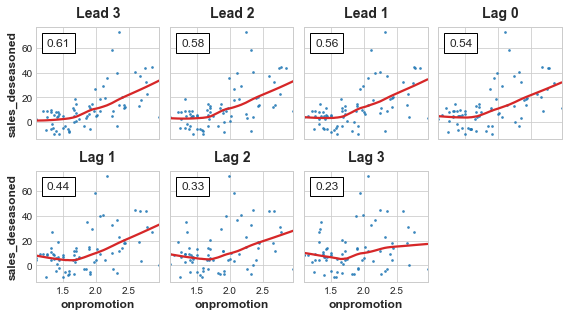

In [6]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=2);

3) Zaman serisi özelliklerini inceleyin (Examine time series features)

Onpromotion'un önde gelen veya geri kalan değerlerinin bir özellik olarak yararlı olabileceği görülüyor mu?

Gecikme grafiği, promosyonun hem önde gelen hem de gecikmeli değerlerinin tedarik satışlarıyla ilişkili olduğunu gösterir.(The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. ) Bu, her iki tür değerin de özellik olarak yararlı olabileceğini düşündürmektedir. Bazı doğrusal olmayan etkiler de olabilir.

4) Zaman serisi özellikleri oluşturun (Create time series features)

Soru 3'ün çözümünde belirtilen özellikleri oluşturun. Bu seriden hiçbir özellik işe yaramazsa, yanıtınız olarak boş bir veri çerçevesi pd.DataFrame() kullanın.

In [7]:
# YOUR CODE HERE: Make features from `y_deseason`
X_lags = make_lags(y_deseason, lags=1)

# YOUR CODE HERE: Make features from `onpromotion`
# You may want to use `pd.concat`
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1)
y, X = y.align(X, join='inner')

y = y.fillna(0.0)
X = X.fillna(0.0)

Ortaya çıkan modelden tahminleri görmek istiyorsanız, sonraki hücredeki kodu kullanın.

Training RMSLE: 0.83205
Validation RMSLE: 1.17316


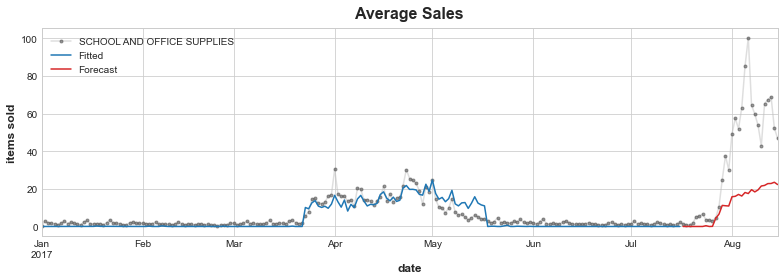

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

# X_train = X_train.fillna(0.0) # burada Nan olan değerleri 0.0 ile doldurdum hata vermesinler diye

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

Kaggle tahmin yarışmalarının kazananları, özellik setlerine genellikle hareketli ortalamaları ve diğer hareketli istatistikleri dahil ettiler. Bu tür özellikler, XGBoost gibi GBDT algoritmaları ile kullanıldığında özellikle faydalı görünmektedir.

Ders 2'de trendleri tahmin etmek için hareketli ortalamaları nasıl hesaplayacağınızı öğrendiniz. Özellik olarak kullanılacak yuvarlanma istatistiklerini (rolling statistics) hesaplamak, ileriye dönük sızıntıyı (lookahead leakage) önlemek için özen göstermemiz gerekmesi dışında benzerdir. İlk olarak, sonuç, merkez yerine pencerenin sağ ucunda ayarlanmalıdır - yani, rolling method (yönteminde) center=False (varsayılan) kullanmalıyız. İkincisi, hedef bir adım ötede olmalıdır.

5) İstatistiksel özellikler oluşturun (Create statistical features)

Aşağıdaki özellikleri oluşturmak için sonraki hücredeki kodu düzenleyin:

- Gecikmeli hedefin 14 günlük hareketli medyanı (medyan)(14-day rolling median (median) of lagged target)
- Gecikmeli hedefin 7 günlük hareketli standart sapması (std)(7-day rolling standard deviation (std) of lagged target)
- Ortalanmış pencere ile "promosyondaki" öğelerin 7 günlük toplamı (toplamı)(7-day sum (sum) of items "on promotion", with centered window)

In [9]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# YOUR CODE HERE: 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# YOUR CODE HERE: 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# YOUR CODE HERE: 7-day sum of promotions with centered window
promo_7 = onpromo.rolling(7, center=True).sum()

Hesaplayabileceğiniz daha fazla istatistik için Pandas [`Window` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/window.html) bakın. Ayrıca rolling yerine ewm kullanarak "üssel ağırlıklı (exponential weighted)" pencereleri deneyin; üssel bozulma (exponential decay) genellikle etkilerin zaman içinde nasıl yayıldığının daha gerçekçi bir temsilidir.